## Applying a 3D convolutional neural network to the data ##

# Handling Data 

In [1]:
import pydicom 
import os 
import pandas as pd 

data_dir = 'stage1/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('stage1_labels.csv', index_col=0)

labels_df.head()

cancer
id                                      
0015ceb851d7251b8f399e39779d1e7d       1
0030a160d58723ff36d73f41b170ec21       0
003f41c78e6acfa92430a057ac0b306e       0
006b96310a37b36cccb2ab48d10b49a3       1
008464bb8521d09a42985dd8add3d0d2       1

At this point, we've got the list of patients by their IDs, and their associated labels stored in a dataframe. Now, we can begin to iterate through the patients and gather their respective data.

In [2]:
for patient in patients[:1]:
    label = labels_df._get_value(patient, 'cancer')
    path = data_dir + patient
    
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(len(slices),label)
    print(slices[0])

134 0
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113654.2.55.247817952625791837963403492891187883824
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0010) Patient's Name                      PN: '00cba091fa4ad62cc3200a657aeb957e'
(0010, 0020) Patient ID                          LO: '00cba091fa4ad62cc3200a657aeb957e'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) KVP                                 DS: ''
(0020, 000d) Study Instance UID                  UI: 2.25.86208730140539712382771890501772734277950692397709007305473
(0020, 000e) Series Instance UID                 UI: 2.25.11575877329635228925808596800269974740893519451784626046614
(0020, 0011) Series Number                       IS: '3'
(0020, 0012) Acquisition Number      

Above, we iterate through each patient, we grab their label, we get the full path to that specific patient (inside THAT path contains ~200 scans which we also iterate over. Also we have sorted it since they wont necessarily be in proper order).

In [3]:
for patient in patients[:3]:
    label = labels_df._get_value(patient, 'cancer')
    path = data_dir + patient
    
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(slices[0].pixel_array.shape, len(slices))

(512, 512) 134
(512, 512) 128
(512, 512) 133


In [4]:
len(patients)

20

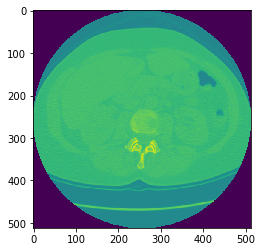

In [5]:
import matplotlib.pyplot as plt

for patient in patients[:1]:
    label = labels_df._get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    plt.imshow(slices[0].pixel_array)
    plt.show()

# Processing and viewing our Data 

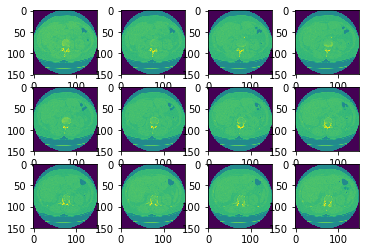

In [6]:
import cv2
import numpy as np

IMG_PX_SIZE = 150

for patient in patients[:1]:
    label = labels_df._get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    fig = plt.figure()
    for num,each_slice in enumerate(slices[:12]):
        y = fig.add_subplot(3,4,num+1)
        new_img = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
        y.imshow(new_img)
    plt.show()

We're resizing our images from 512x512 to 150x150.

In [7]:
import math

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def mean(l):
    return sum(l) / len(l)

IMG_PX_SIZE = 150
HM_SLICES = 20

data_dir = 'stage1/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('stage1_labels.csv', index_col=0)

for patient in patients[:10]:
    try:
        label = labels_df._get_value(patient, 'cancer')
        path = data_dir + patient
        slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        new_slices = []
        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
        chunk_sizes = math.ceil(len(slices) / HM_SLICES)
        for slice_chunk in chunks(slices, chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        print(len(slices), len(new_slices))
    except:
        # some patients don't have labels, so we'll just pass on this for now
        pass

134 20
128 19
133 19
110 19
203 19
280 20
123 18
164 19
244 19


In [8]:
for patient in patients[:10]:
    try:
        label = labels_df._get_value(patient, 'cancer')
        path = data_dir + patient
        slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        new_slices = []

        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]

        chunk_sizes = math.ceil(len(slices) / HM_SLICES)


        for slice_chunk in chunks(slices, chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        if len(new_slices) == HM_SLICES-1:
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES-2:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES+2:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        if len(new_slices) == HM_SLICES+1:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        print(len(slices), len(new_slices))
    except Exception as e:
        print(str(e))

134 20
128 20
133 20
110 20
203 20
'0b20184e0cd497028bdd155d9fb42dc9'
280 20
123 20
164 20
244 20


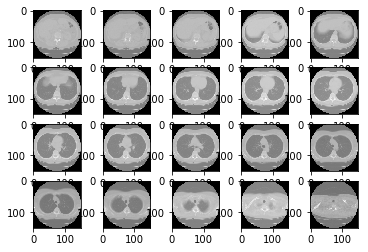

In [9]:
for patient in patients[:1]:
    label = labels_df._get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    new_slices = []

    slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / HM_SLICES)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == HM_SLICES-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES+2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
        
    if len(new_slices) == HM_SLICES+1:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
    
    fig = plt.figure()
    for num,each_slice in enumerate(new_slices):
        y = fig.add_subplot(4,5,num+1)
        y.imshow(each_slice, cmap='gray')
    plt.show()

# Preprocessing our Data 

In [10]:
import numpy as np
import pandas as pd
import dicom
import os
import matplotlib.pyplot as plt
import cv2
import math

IMG_SIZE_PX = 50
SLICE_COUNT = 20

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]


def mean(a):
    return sum(a) / len(a)


def process_data(patient,labels_df,img_px_size=50, hm_slices=20, visualize=False):
    
    label = labels_df._get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

    new_slices = []
    slices = [cv2.resize(np.array(each_slice.pixel_array),(img_px_size,img_px_size)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / hm_slices)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == hm_slices-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices+2:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val
        
    if len(new_slices) == hm_slices+1:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val

    if visualize:
        fig = plt.figure()
        for num,each_slice in enumerate(new_slices):
            y = fig.add_subplot(4,5,num+1)
            y.imshow(each_slice, cmap='gray')
        plt.show()

    if label == 1: label=np.array([0,1])
    elif label == 0: label=np.array([1,0])
        
    return np.array(new_slices),label

data_dir = 'stage1/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('stage1_labels.csv', index_col=0)

much_data = []
for num,patient in enumerate(patients):
    if num % 100 == 0:
        print(num)
    try:
        img_data,label = process_data(patient,labels,img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        much_data.append([img_data,label])
    except KeyError as e:
        print('This is unlabeled data!')

np.save('muchdata-{}-{}-{}.npy'.format(IMG_SIZE_PX,IMG_SIZE_PX,SLICE_COUNT), much_data)

0
This is unlabeled data!


# 3D Convolutional Neural Network 

In [11]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np

IMG_SIZE_PX = 50
SLICE_COUNT = 20

n_classes = 2
batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8

In [12]:
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')

Now we're ready for the network itself:

In [13]:
def convolutional_neural_network(x):
    # 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               # 5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               # 64 features
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

Now we're set to train the network. Our training file should be ~700mb with ~1400 total labeled samples.

In [14]:
much_data = np.load('muchdata-50-50-20.npy')
train_data = much_data[:-100]
validation_data = much_data[-100:]


def train_neural_network(x):
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(prediction,y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    
    hm_epochs = 10
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        successful_runs = 0
        total_runs = 0
        
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for data in train_data:
                total_runs += 1
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    pass
                    print(str(e))
            
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
            
        print('Done. Finishing accuracy:')
        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        
        print('fitment percent:',successful_runs/total_runs)


train_neural_network(x)

Epoch 1 completed out of 10 loss: 195148607547.0

Accuracy: 0.63

Epoch 2 completed out of 10 loss: 14236109414.9

Accuracy: 0.6

Epoch 3 completed out of 10 loss: 5744945978.94

Accuracy: 0.7

Epoch 4 completed out of 10 loss: 3268944715.44

Accuracy: 0.6

Epoch 5 completed out of 10 loss: 1916325681.66

Accuracy: 0.6

Epoch 6 completed out of 10 loss: 1014763813.3

Accuracy: 0.46

Epoch 7 completed out of 10 loss: 680146186.953

Accuracy: 0.54

Epoch 8 completed out of 10 loss: 289082075.259

Accuracy: 0.62

Epoch 9 completed out of 10 loss: 122785997.913

Accuracy: 0.57

Epoch 10 completed out of 10 loss: 96427552.5371

Accuracy: 0.51

Done. Finishing accuracy:

Accuracy: 0.69

fitment percent: 0.9992289899768697


# Concluding Remarks 

In [15]:
labels_df.cancer.value_counts()

0    1035
1     362
Name: cancer, dtype: int64

So, actually, our dataset has 1035 non-cancer examples and 362 cancerous examples. Thus, an algorithm that always predicted no-cancer with our model would be ~ 74% accurate (1035/1397).

In [16]:
labels_df.ix[-100:].cancer.value_counts()

0    72
1    28
Name: cancer, dtype: int64